In [218]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt

In [52]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Dropout, BatchNormalization
print(tf.__version__)

2.3.0


In [3]:
dataset = pd.read_csv("ZY set.csv",index_col=0)
test = pd.read_csv("ZY test set.csv",index_col=0)

#Stock market prices
y = dataset.iloc[:,10:13]
y_test = test.iloc[:,10:13]

#Rearrange so stock market prices are at the end
dataset = dataset.iloc[:,np.r_[:10,13:len(dataset.columns)]]
dataset = pd.concat([dataset,y],axis=1)

test = test.iloc[:,np.r_[:10,13:len(test.columns)]]
test = pd.concat([test,y_test],axis=1)

### train-test split

In [5]:
train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#### predict GSPC original

In [6]:
train_feature = train_dataset.iloc[:,:-3].copy()
test_feature = test_dataset.iloc[:,:-3].copy()

train_gspc = train_dataset['^GSPC']
test_gspc = test_dataset['^GSPC']

In [7]:
# normalise
normalizer = preprocessing.Normalization(input_shape=[84,])
normalizer.adapt(np.array(train_feature))

In [167]:
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
  )

# create model
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 84)                169       
_________________________________________________________________
dense_320 (Dense)            (None, 64)                5440      
_________________________________________________________________
dense_321 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_322 (Dense)            (None, 1)                 65        
Total params: 9,834
Trainable params: 9,665
Non-trainable params: 169
_________________________________________________________________


In [20]:
history = dnn_model.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=400,callbacks=[stopper])

In [21]:
def plot_loss(history, ylimt=3000):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, ylimt])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

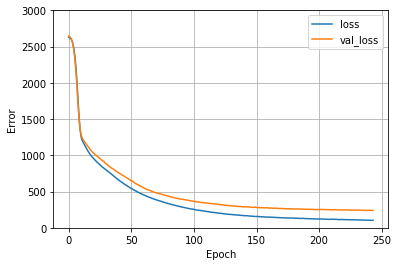

In [22]:
plot_loss(history)

In [23]:
# retrieve the MAPE on the test set

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

mean_absolute_percentage_error(test_gspc, dnn_model.predict(test_feature)) #MAPE

8.920365238989419

In [24]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_gspc))

344.2987429096365

### tuning

#### 1. Increase the number of hidden layers to 5

In [229]:
# create model
def build_and_compile_model_layer(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),       
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model_layer = build_and_compile_model_layer(normalizer)
dnn_model_layer.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 84)                169       
_________________________________________________________________
dense_386 (Dense)            (None, 64)                5440      
_________________________________________________________________
dense_387 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_388 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_389 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_390 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_391 (Dense)            (None, 1)               

In [230]:
history_layer = dnn_model_layer.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=400,callbacks=[stopper])

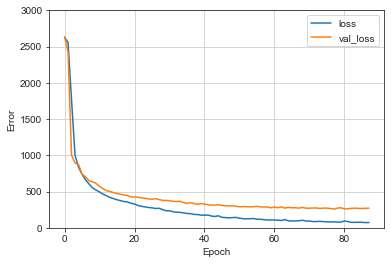

In [231]:
plot_loss(history_layer)

In [232]:
mean_absolute_percentage_error(test_gspc, dnn_model_layer.predict(test_feature)) #MAPE

10.537976173691277

In [125]:
# RMSE
sqrt(mean_squared_error(dnn_model_layer.predict(test_feature), test_gspc))

408.75305747033116

#### 2. Increase the size of each layer to 128

In [115]:
# create model
def build_and_compile_model_size(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(128, activation='relu'),    
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model_size = build_and_compile_model_size(normalizer)
dnn_model_size.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 84)                169       
_________________________________________________________________
dense_233 (Dense)            (None, 128)               10880     
_________________________________________________________________
dense_234 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_235 (Dense)            (None, 1)                 129       
Total params: 27,690
Trainable params: 27,521
Non-trainable params: 169
_________________________________________________________________


In [116]:
history_size = dnn_model_size.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=400,callbacks=[stopper])

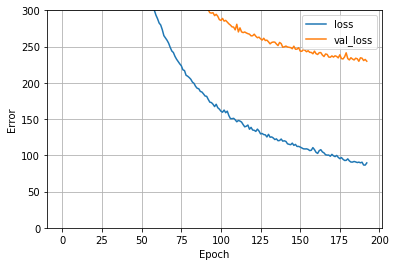

In [117]:
plot_loss(history_size, 300)

In [118]:
# MAPE
mean_absolute_percentage_error(test_gspc, dnn_model_size.predict(test_feature)) 

8.925374707079655

In [119]:
# RMSE
sqrt(mean_squared_error(dnn_model_size.predict(test_feature), test_gspc))

357.616442685152

#### 3. Change the activation function to sigmoid

In [37]:
# create model
def build_and_compile_model_fn(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(128, activation='sigmoid'),    
      layers.Dense(1)
  ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model_fn = build_and_compile_model_fn(normalizer)
dnn_model_fn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 84)                169       
_________________________________________________________________
dense_21 (Dense)             (None, 128)               10880     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 27,690
Trainable params: 27,521
Non-trainable params: 169
_________________________________________________________________


In [38]:
history_fn = dnn_model_fn.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=400,callbacks=[stopper])

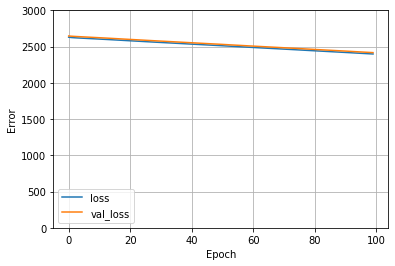

In [39]:
plot_loss(history_fn)

In [40]:
# MAPE
mean_absolute_percentage_error(test_gspc, dnn_model_fn.predict(test_feature)) 

90.94390077768145

In [41]:
# RMSE
sqrt(mean_squared_error(dnn_model_fn.predict(test_feature), test_gspc))

2447.9672901400654

### Adding it all together, increasing number of layers of same type does not help, increasing layer unit helps and sigmoid does not help.

Therefore, we will use a bottleneck architecture of [512,256,128,64] of 2 layers each, and continue with relu activation. Furthermore, based on https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/ , we will introduce Batchnormalization and Dropout layers.

In [193]:
def build_and_compile_model(norm):
    model = keras.Sequential()
    model.add(norm)
    for i in [512,256,128,64]:
        for j in range(2):
            model.add(layers.Dense(i,activation='relu'))
            model.add(BatchNormalization())
            model.add(Dropout(0.1))
            
    model.add(layers.Dense(1))

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 84)                169       
_________________________________________________________________
dense_344 (Dense)            (None, 512)               43520     
_________________________________________________________________
batch_normalization_181 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_206 (Dropout)        (None, 512)               0         
_________________________________________________________________
dense_345 (Dense)            (None, 512)               262656    
_________________________________________________________________
batch_normalization_182 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_207 (Dropout)        (None, 512)             

In [194]:
history_fn = dnn_model.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=400,callbacks=[stopper])

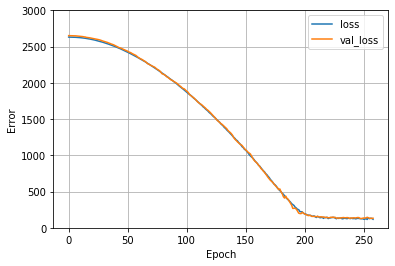

In [195]:
plot_loss(history_fn)

In [196]:
# MAPE
mean_absolute_percentage_error(test_gspc, dnn_model.predict(test_feature)) 

4.845916735949514

In [197]:
# RMSE
sqrt(mean_squared_error(dnn_model.predict(test_feature), test_gspc))

193.54046120706664

## Test data prediction

In [199]:
dnn_model = build_and_compile_model(normalizer)

history_fn = dnn_model.fit(
    train_feature, train_gspc,
    validation_split=0.2,
    verbose=0, epochs=400,callbacks=[stopper])

GSPC_pred = dnn_model.predict(test.iloc[:,:-3])

In [200]:
train_ixic = train_dataset['^IXIC']

dnn_model = build_and_compile_model(normalizer)

history_ixic = dnn_model.fit(
    train_feature, train_ixic,
    validation_split=0.2,
    verbose=0, epochs=400,callbacks=[stopper])

IXIC_pred = dnn_model.predict(test.iloc[:,:-3])

In [201]:
train_vgt = train_dataset['VGT']

dnn_model = build_and_compile_model(normalizer)

history_vgt = dnn_model.fit(
    train_feature, train_vgt,
    validation_split=0.2,
    verbose=0, epochs=500,callbacks=[stopper])

VGT_pred = dnn_model.predict(test.iloc[:,:-3])

In [202]:
GSPC_pred = [x[0] for x in GSPC_pred]
IXIC_pred = [x[0] for x in IXIC_pred]
VGT_pred = [x[0] for x in VGT_pred]

In [225]:
print("GSPC metrics")
print("RMSE: %.3f, MAPE:%.3f"%(sqrt(mean_squared_error(GSPC_pred,test.reset_index()['^GSPC'])),
                               mean_absolute_percentage_error(test.reset_index()['^GSPC'], GSPC_pred)))
print("\n")
print("IXIC metrics")
print("RMSE: %.3f, MAPE:%.3f"%(sqrt(mean_squared_error(IXIC_pred,test.reset_index()['^IXIC'])),
                               mean_absolute_percentage_error(test.reset_index()['^IXIC'], IXIC_pred)))
print("\n")
print("VGT metrics")
print("RMSE: %.3f, MAPE:%.3f"%(sqrt(mean_squared_error(VGT_pred,test.reset_index()['VGT'])),
                               mean_absolute_percentage_error(test.reset_index()['VGT'], VGT_pred)))

GSPC metrics
RMSE: 456.764, MAPE:10.927


IXIC metrics
RMSE: 2837.708, MAPE:22.172


VGT metrics
RMSE: 83.895, MAPE:23.194


In [216]:
# obtain time series plots of acutual prices and forecasts prices for GSPC, IXIC and VGT

def plot_predictions(test,
                     set3_GSPC_pred, set3_IXIC_pred, set3_VGT_pred
                    ):
    import matplotlib.ticker as ticker
    test_df_grouped = test.groupby('market_date').mean().reset_index()
    
    # obtain dataframes that contain predictions and the actual prices
    GSPC_pred_df = pd.DataFrame({'market_date':test_df_grouped['market_date'],
                                  'actual_GSPC':test_df_grouped['^GSPC'],
                                  'set3_GSPC_pred':set3_GSPC_pred
                                 }).set_index('market_date')
    
    IXIC_pred_df = pd.DataFrame({'market_date':test_df_grouped['market_date'],
                                  'actual_IXIC':test_df_grouped['^IXIC'],
                                  'set3_IXIC_pred':set3_IXIC_pred
                                 }).set_index('market_date')
    
    VGT_pred_df = pd.DataFrame({'market_date':test_df_grouped['market_date'],
                                'actual_VGT':test_df_grouped['VGT'],
                                'set3_VGT_pred':set3_VGT_pred
                                }).set_index('market_date')    
    
    # matplotlib and seaborn settings
    sns.set_style("ticks")
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,12))
    plt.subplots_adjust(hspace=0.5)
   
    # generate plots
    GSPC = sns.lineplot(data=GSPC_pred_df, ax=axes[0])
    GSPC.xaxis.set_major_locator(ticker.MultipleLocator(2))
    GSPC.legend(loc='center right', bbox_to_anchor=(1.17, 0.5), ncol=1)
    axes[0].title.set_text("GSPC predictions")
    
    IXIC = sns.lineplot(data=IXIC_pred_df, ax=axes[1])
    IXIC.xaxis.set_major_locator(ticker.MultipleLocator(2))
    IXIC.legend(loc='center right', bbox_to_anchor=(1.17, 0.5), ncol=1)
    axes[1].title.set_text("IXIC predictions")
    
    VGT = sns.lineplot(data=VGT_pred_df, ax=axes[2])
    VGT.xaxis.set_major_locator(ticker.MultipleLocator(2))
    VGT.legend(loc='center right', bbox_to_anchor=(1.17, 0.5), ncol=1)
    axes[2].title.set_text("VGT predictions")
    
    plt.savefig("time_series_prediction.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return GSPC_pred_df, IXIC_pred_df, VGT_pred_df

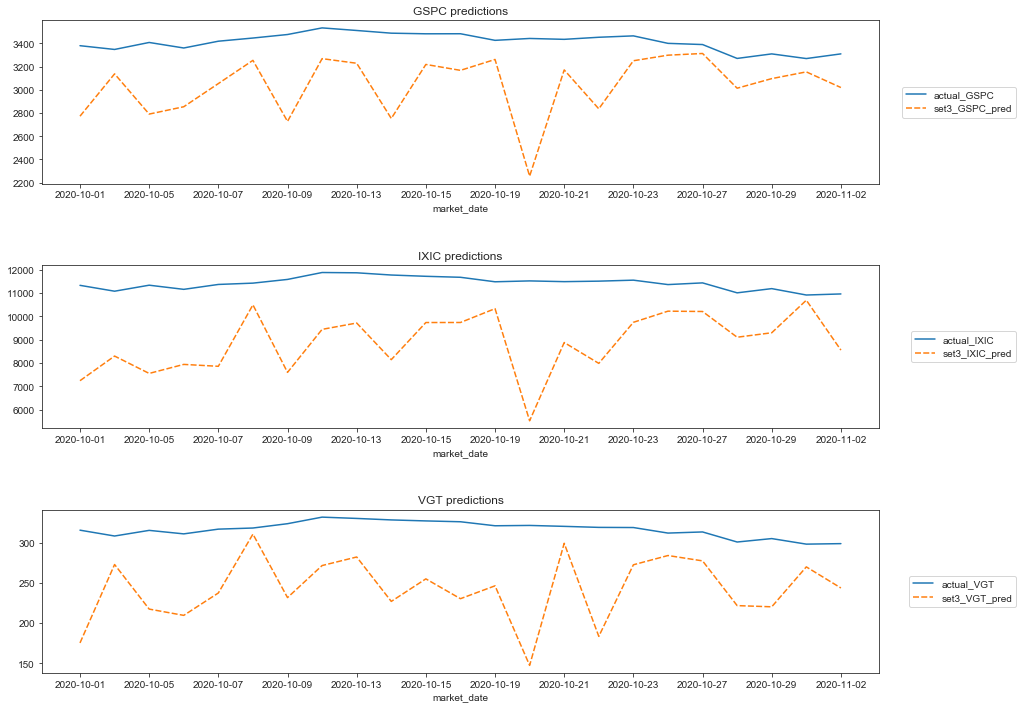

In [217]:
GSPC_pred_df, IXIC_pred_df, VGT_pred_df = plot_predictions(test.reset_index(),
                                                           GSPC_pred, IXIC_pred, VGT_pred
                                                          )